# Run ISC

This script finds the networks that exhibit a decrease in ISC over time. Specifically, the 'vis' version perfroms sevral different plotting functions

## py conversion

In [1]:
#jupyter nbconvert --to python slurm_create-data_preproc.ipynb

## Imports 

In [78]:
import warnings
import sys  
import random
import os
import os.path

import deepdish as dd
import numpy as np
import pandas as pd

import scipy.io
from scipy import stats
from scipy.stats import stats
from scipy.stats import norm, zscore, pearsonr
from scipy.signal import gaussian, convolve

#plotting
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import seaborn as sns 

# nil and nib 
import nibabel as nib
import nilearn as nil

from nilearn.input_data import NiftiMasker
from nilearn import datasets, plotting
from nilearn.plotting import plot_roi
from nilearn.input_data import NiftiSpheresMasker
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.image import concat_imgs, resample_img, mean_img,index_img
from nilearn import image
from nilearn import masking
from nilearn.plotting import view_img
from nilearn.image import resample_to_img
from nilearn.image import concat_imgs, resample_img, mean_img
from nilearn.plotting import view_img
from nilearn.input_data import NiftiMasker
from nilearn.masking import compute_epi_mask, compute_brain_mask, unmask
from nilearn.plotting import plot_stat_map

# Brainiak # 
from brainiak import image, io 
import brainiak.utils.fmrisim as sim  
from brainiak import image, io
import brainiak.eventseg.event
from brainiak.isc import (isc, isfc, bootstrap_isc, permutation_isc,
                          timeshift_isc, phaseshift_isc,
                          compute_summary_statistic)
from brainiak.io import load_boolean_mask, load_images
from statsmodels.stats.multitest import multipletests

from brainiak.isc import squareform_isfc
%matplotlib inline

In [79]:
random.seed(10)

## custom helper functions 

In [80]:
## imports
from utils_anal import load_epi_data, resample_atlas, get_network_labels

## directories 

In [81]:
top_dir = '/jukebox/graziano/coolCatIsaac/MEI'
data_dir = top_dir + "/data"
work_dir = data_dir + '/work'
mask_dir = work_dir + '/masks'
behav_dir = top_dir + '/data/behavioral'
rois_dir = data_dir + "/rois"
fmri_prep = data_dir + '/bids/derivatives/fmriprep'
conf_dir = work_dir + '/confs'
preproc_dir = work_dir + '/preproc'
isc_dir = work_dir + '/isc_dat'


# get correlation dic for 7 nets 

In [26]:
##### Variables for ISC ### 

num_parc = 200 ## CHANGE ME
num_net= 7 ## CHANGE ME


###### ROI Loading ### 
# LOAD ATLAS #
## fetch dataset
dataset = datasets.fetch_atlas_schaefer_2018(n_rois=num_parc, yeo_networks = num_net)

# get nii dataset location
atlas_filename = dataset.maps
## get *ROI* atlas labels
labels = dataset.labels

# resample loaded atlas 
atlas_nii, atlas_img = resample_atlas(atlas_filename, fmri_prep)

# Load in network labels for each parcell, parcel UNspecific network labels, and the middle parcel within each network
networks, network_labels, network_idxs = get_network_labels(num_parc, num_net)

## mask info ##
ref_nii = nib.load(mask_dir + "/whole_b_bnk.nii.gz")
mask_img = load_boolean_mask(mask_dir + "/whole_b_bnk.nii.gz")
mask_coords = np.where(mask_img)

Loading data from /jukebox/graziano/coolCatIsaac/MEI/data/bids/derivatives/fmriprep/sub-007/ses-01/func/sub-007_ses-01_task-None_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
shape of run 2 is (78, 93, 65, 369) 

count parc:201
shape of atlas nii object (78, 93, 65)
two networks: ['L Vis', 'L SomMot'] 
 total nets: 14


# DO rois 

In [91]:
# load unthresh image 
#isc_nii_nt_all = np.load(f'{isc_dir}/n_33_isc_noThresh_nii_dic.npy', allow_pickle = True).item()
isc_nii_nt_all = np.load(f'{isc_dir}/n39_isc_noThresh_nii_dic.npy', allow_pickle = True).item()


In [97]:
mov = 'sherlock'
cond = 'internal'
run_list = [1,2,3,4]
# static
cor_dic = {cond: {mov: {}  for mov in mov_list} for cond in cond_list}

In [98]:
isc_nii_nt = isc_nii_nt_all[cond][mov]
isc_nii_nt

{1: <nibabel.nifti1.Nifti1Image at 0x7fb286b703d0>,
 2: <nibabel.nifti1.Nifti1Image at 0x7fb286b70490>,
 3: <nibabel.nifti1.Nifti1Image at 0x7fb286b70550>,
 4: <nibabel.nifti1.Nifti1Image at 0x7fb286b70610>}

In [99]:
for run in run_list:
    # Convert to 4d numpy array
    f_dat_4d = isc_nii_nt[run].get_fdata()

    for net_lab in network_labels:
        targ_net = (np.array(networks) == net_lab).nonzero()[0] + 1
        #print(net_lab)

        temp = [np.nanmean([np.nanmean(f_dat_4d[atlas_img == parcel])]) for parcel in targ_net]
        if net_lab not in cor_dic[cond][mov]:
            cor_dic[cond][mov][net_lab] = [np.round(np.nanmean(temp),5)]
            #print(np.round(np.nanmean(temp),5))
        else:
            cor_dic[cond][mov][net_lab].append(np.round(np.nanmean(temp),5))

In [100]:
cor_dic[cond][mov]

{'L Vis': [0.22994, 0.14676, 0.10135, 0.10271],
 'L SomMot': [0.11481, 0.05714, 0.06558, 0.05614],
 'L DorsAttn': [0.14084, 0.09345, 0.03316, 0.03957],
 'L SalVentAttn': [0.0889, 0.04687, 0.02865, 0.03901],
 'L Limbic': [0.03086, 0.00713, 0.00571, 0.01354],
 'L Cont': [0.09396, 0.0338, 0.01298, 0.01663],
 'L Default': [0.11511, 0.06898, 0.0527, 0.03415],
 'R Vis': [0.22575, 0.14559, 0.11311, 0.09946],
 'R SomMot': [0.12596, 0.05991, 0.0569, 0.07491],
 'R DorsAttn': [0.14895, 0.10183, 0.05273, 0.0591],
 'R SalVentAttn': [0.11482, 0.08451, 0.07288, 0.07599],
 'R Limbic': [0.02615, 0.01501, 0.00385, 0.01126],
 'R Cont': [0.0759, 0.05352, 0.01458, 0.02628],
 'R Default': [0.11624, 0.10112, 0.08141, 0.05401]}

# Visualize

## 7 NETWORK PLOTTING 

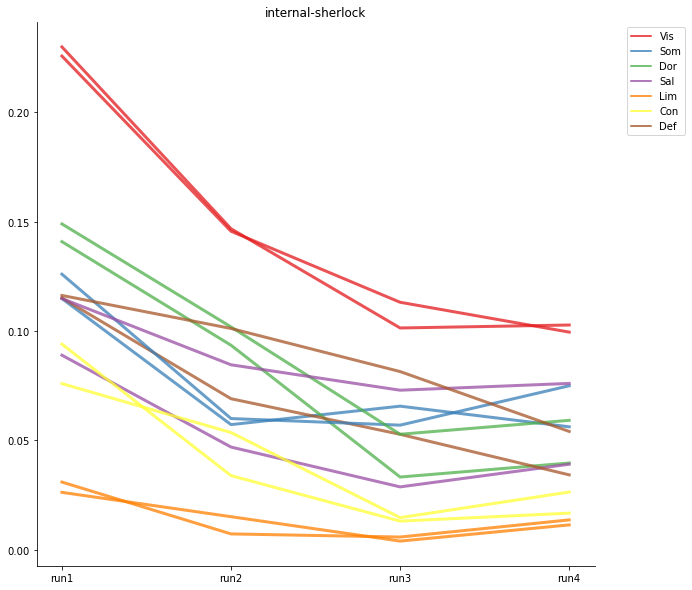

In [101]:
fig, ax = plt.subplots(figsize=(10, 10))
xlabs = ['run1', 'run2', 'run3', 'run4']

color_mapping = {}
handles = []
for key in cor_dic[cond][mov]:
    prefix = key.split()[1][:3]  # Get the prefix of the key
    if prefix not in color_mapping:
        color_mapping[prefix] = sns.color_palette("Set1", n_colors=len(color_mapping) + 1)[len(color_mapping)]
        handles.append(ax.plot([], [], label=prefix, color=color_mapping[prefix])[0])  # Add a dummy line handle for the legend

    ax.plot(cor_dic[cond][mov][key], color=color_mapping[prefix], alpha=0.75, linewidth = 3)

ax.set_xticks(range(len(xlabs)))
ax.set_xticklabels(xlabs)
ax.set_title(f'{cond}-{mov}')

plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()
plt.show()


### plot each line 

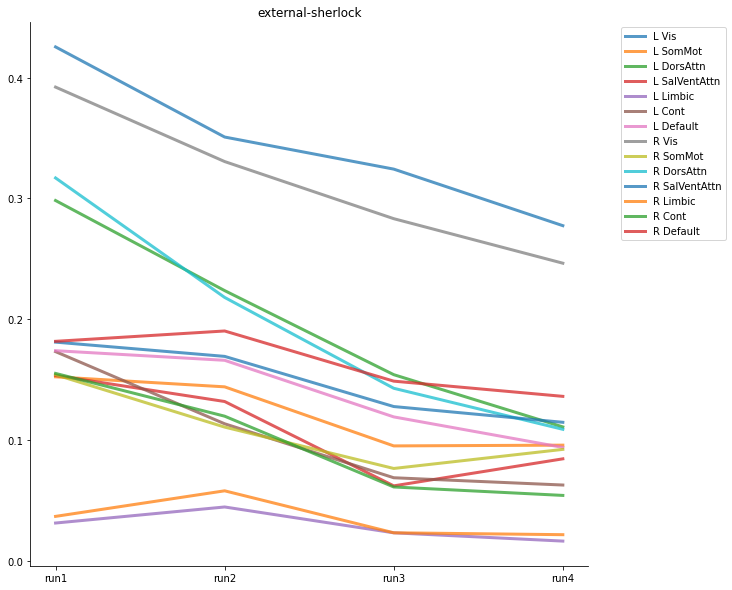

In [63]:
fig, ax = plt.subplots(figsize=(10, 10))
xlabs = ['run1', 'run2', 'run3', 'run4']

color_mapping = {}
handles = []
for key in cor_dic[cond][mov]:
    line, = ax.plot(cor_dic[cond][mov][key], alpha=0.75, linewidth=3)
    handles.append(line)  # Add the line object to handles list for legend
    
ax.set_xticks(range(len(xlabs)))
ax.set_xticklabels(xlabs)
ax.set_title(f'{cond}-{mov}')

# Set legend labels to the keys
plt.legend(handles=handles, labels=cor_dic[cond][mov].keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

sns.despine()
plt.show()


## plot a couple of networks

In [92]:
conditions = ['External', "Internal"]
mov = 'sherlock'
networkz = [ 'L VisCent', 'L DefaultB', 'L DefaultC', 'L DefaultA'] #'R DorsAttnB'
new_dic = {}
for cond in conditions:
    for key in cor_dic:
        key_splits = key.split('-')
        if key_splits[0] == cond and key_splits[1] == mov and key_splits[2] in networkz:
            print(key)
            new_dic[cond + '-' + key_splits[2]] = cor_dic[key]

External-sherlock-L VisCent
External-sherlock-L DefaultA
External-sherlock-L DefaultB
External-sherlock-L DefaultC


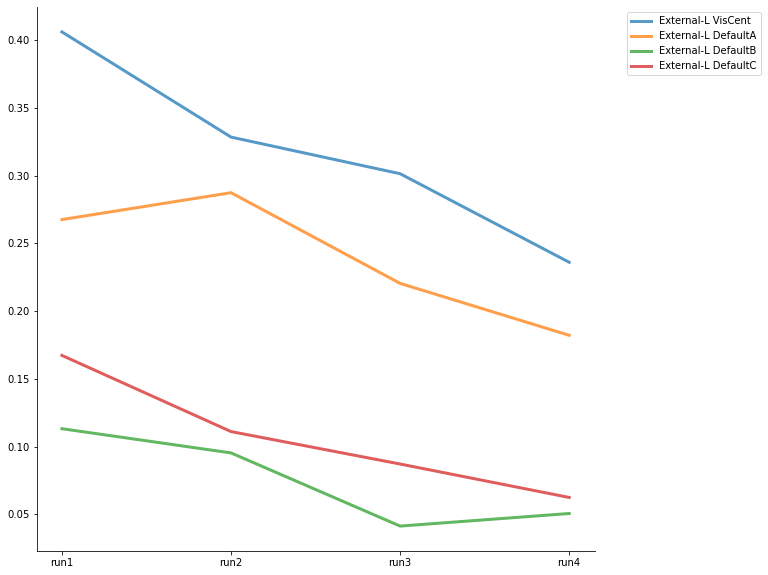

In [93]:
fig, ax = plt.subplots(figsize=(10, 10))
xlabs = ['run1', 'run2', 'run3', 'run4']

color_mapping = {}
handles = []
for key in new_dic:
    line, = ax.plot(new_dic[key], alpha=0.75, linewidth=3, label=key)
    handles.append(line)

ax.set_xticks(range(len(xlabs)))
ax.set_xticklabels(xlabs)
ax.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()
plt.show()

In [82]:
5+5

10

## bar graph of voxels

In [83]:
sigvox = np.load(f'{isc_dir}/isc_sigvox_nii_dic.npy', allow_pickle = True).item()
#sigvox = np.load(f'{isc_dir}/n33_isc_sigvox_nii_dic.npy', allow_pickle = True).item()

In [87]:
run_list = [1, 2, 3, 4]
cond_list = ["internal", "external"]
cond = 'internal'
mov_list = ['sherlock', 'office',  'shrek', 'cake', 'brushing', 'oragami']


In [88]:
sigvox[cond]['office']

{1: <nibabel.nifti1.Nifti1Image at 0x7fb284de3550>,
 2: <nibabel.nifti1.Nifti1Image at 0x7fb284e63210>,
 3: <nibabel.nifti1.Nifti1Image at 0x7fb286ac5c50>,
 4: <nibabel.nifti1.Nifti1Image at 0x7fb284e63650>}

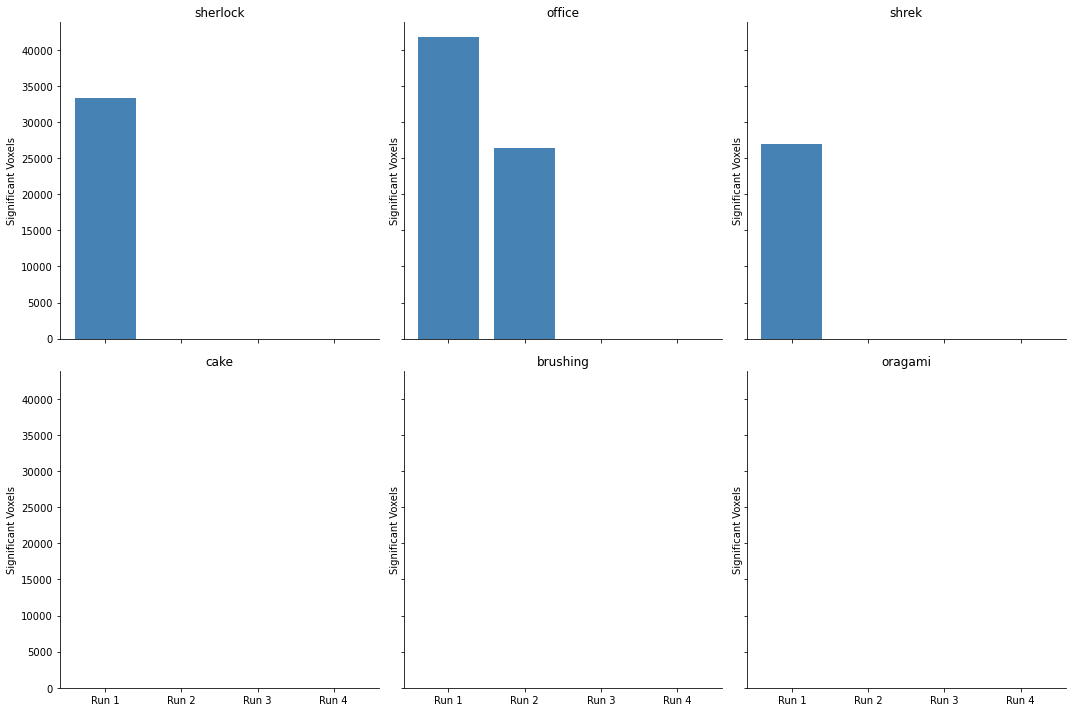

In [89]:
# Sample data
x_labels = ['Run 1', 'Run 2', 'Run 3', 'Run 4']

# Create 6 subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10), sharex = True, sharey = True)

for idx, mov in enumerate(mov_list):
    run_count = []
    for run in run_list:
        x_3d = sigvox[cond][mov][run].get_fdata()
        run_count.append(x_3d[x_3d > 0].shape[0])
    ax = axes[int(idx / 3), idx % 3]
    ax.bar(x_labels, run_count, color='steelblue')
    ax.set_title(f'{mov}')
    #ax.set_xlabel('Runs')
    ax.set_ylabel('Significant Voxels')
        


# Adjust spacing between subplots
plt.tight_layout()
sns.despine()

# Show the plot
plt.show()
        
        
        

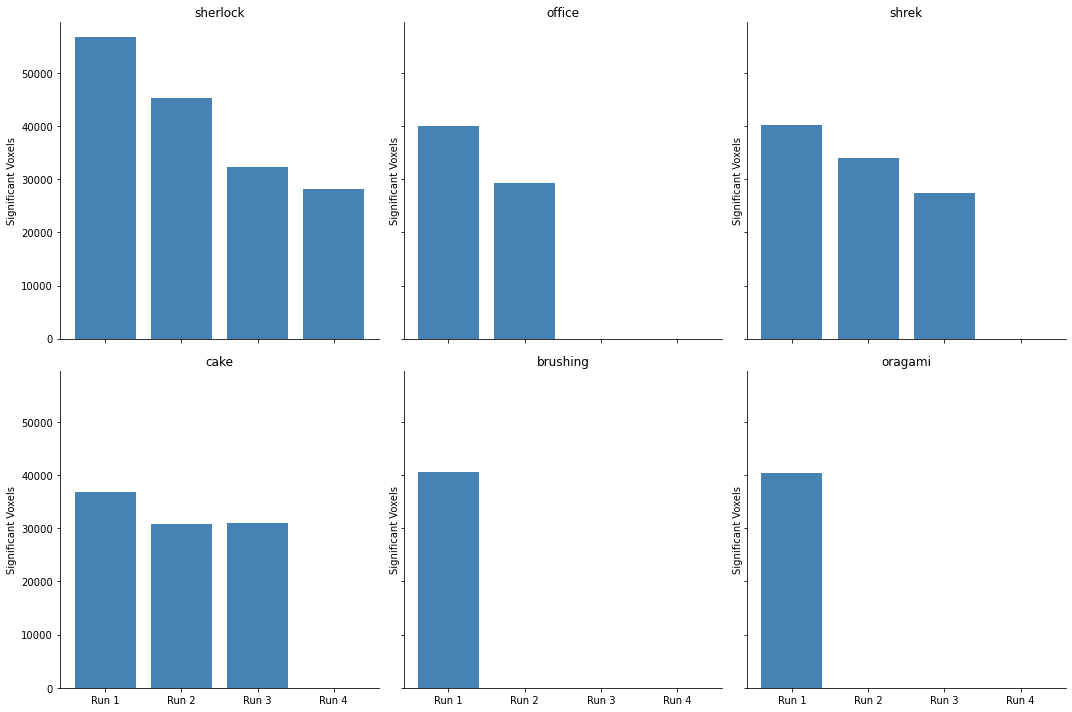

In [42]:
# Sample data
x_labels = ['Run 1', 'Run 2', 'Run 3', 'Run 4']

# Create 6 subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10), sharex = True, sharey = True)

for idx, mov in enumerate(mov_list):
    run_count = []
    for run in run_list:
        x_3d = sigvox[cond][mov][run].get_fdata()
        run_count.append(x_3d[x_3d > 0].shape[0])
    ax = axes[int(idx / 3), idx % 3]
    ax.bar(x_labels, run_count, color='steelblue')
    ax.set_title(f'{mov}')
    #ax.set_xlabel('Runs')
    ax.set_ylabel('Significant Voxels')
        


# Adjust spacing between subplots
plt.tight_layout()
sns.despine()

# Show the plot
plt.show()
        
        
        

In [127]:
# Threshold value
threshold = 0.03

# Get a boolean mask for values greater than the threshold
mask = x_3d < threshold

# Use the boolean mask to extract values from the original array
values_above_threshold = x_3d[mask]

print(values_above_threshold.shape)

(5,)


In [128]:
nonnan_mask = ~np.isnan(x_3d)
nonnan_mask[nonnan_mask == True].shape

(40612,)

In [ ]:
for key in vis_dic: 

In [136]:
list(vis_dic.keys())[:3]

['Internal-office-1', 'Internal-brushing-1', 'Internal-oragami-1']

In [ ]:
conditions = ['External', "Internal"]
mov = 'sherlock'
external = {}
internal = {}

for cond in conditions:
    for key in cor_dic:
        key_splits = key.split('-')
        if key_splits[0] == cond and key_splits[1] == mov and key_splits[2] in networkz:
            print(key)
            new_dic[cond + '-' + key_splits[2]] = cor_dic[key]

# rerun ISC to get raw correlations, not q values

In [19]:
from utils_anal import load_epi_data, resample_atlas, get_network_labels

In [20]:
## here we just remove the portion of the code that threshholds 
runs = [1, 2, 3, 4]
conditions = ["External"]
mov_list = ['office', 'brushing', 'origami', 'shrek', 'cake', 'sherlock']
#mov_list = [ 'sherlock']



remove_trs = 4
vis_dic = {}

In [21]:
num_parc = 200 ## CHANGE ME
num_net= 17 ## CHANGE ME


In [22]:
# LOAD ATLAS #
## fetch dataset
dataset = datasets.fetch_atlas_schaefer_2018(n_rois=num_parc, yeo_networks = num_net)

# get nii dataset location
atlas_filename = dataset.maps
## get *ROI* atlas labels
labels = dataset.labels

# resample loaded atlas 
atlas_nii, atlas_img = resample_atlas(atlas_filename, fmri_prep)


# ### get network labels

# Load in network labels for each parcell, parcel UNspecific network labels, and the middle parcel within each network
networks, network_labels, network_idxs = get_network_labels(num_parc, num_net)

Loading data from /jukebox/graziano/coolCatIsaac/MEI/data/bids/derivatives/fmriprep/sub-007/ses-01/func/sub-007_ses-01_task-None_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
shape of run 2 is (78, 93, 65, 369) 

count parc:201
shape of atlas nii object (78, 93, 65)
two networks: ['L VisCent', 'L VisPeri'] 
 total nets: 34


In [23]:
for net_lab in network_labels:
    targ_net = (np.array(networks) == net_lab).nonzero()[0] + 1
    print(net_lab)

L VisCent
L VisPeri
L SomMotA
L SomMotB
L DorsAttnA
L DorsAttnB
L SalVentAttnA
L SalVentAttnB
L LimbicB
L LimbicA
L ContA
L ContB
L ContC
L DefaultA
L DefaultB
L DefaultC
L TempPar
R VisCent
R VisPeri
R SomMotA
R SomMotB
R DorsAttnA
R DorsAttnB
R SalVentAttnA
R SalVentAttnB
R LimbicB
R LimbicA
R ContA
R ContB
R ContC
R DefaultA
R DefaultB
R DefaultC
R TempPar


In [75]:
## mask image ##
ref_nii = nib.load(mask_dir + "/whole_b_bnk.nii.gz")
mask_img = load_boolean_mask(mask_dir + "/whole_b_bnk.nii.gz")

# Get coordinates of mask voxels in original image
mask_coords = np.where(mask_img)

In [73]:
## load ISC 
loaded_int_isc = np.load(f'{isc_dir}/int_isc.npz')
loaded_ext_isc = np.load(f'{isc_dir}/ext_isc.npz')
## get template image #
vis_dic = np.load(f'{isc_dir}/vis_dic_nothresh.npy', allow_pickle=True).item()
bpress_nii = vis_dic['External-sherlock-1']
#number of bootstraps: 
n_boot = 5

In [71]:
conditions = ['External', 'Internal']

['External', 'Internal']

In [76]:
for cond in conditions:
    print(f'START {cond}')
    if cond == "External":
        targ_dic = loaded_ext_isc
    else:
        targ_dic = loaded_int_isc
        
    for run in runs:
        for mov in mov_list:
    
            # select movie and run from loaded data ** account for indexing
            data = targ_dic[mov][...,run - 1,:]
            print('loaded!')
            print(f'{mov} run {run} shape is: {data.shape}')

            # Z-score time series for each voxel
            data = zscore(data[remove_trs:,:,:], axis=0)

            # Leave-one-out approach
            iscs = isc(data, pairwise=False, tolerate_nans=.8)

            # Check shape of output ISC values
            print(f"ISC values shape = {iscs.shape} \ni.e., {iscs.shape[0]} "
                  f"left-out subjects and {iscs.shape[1]} voxel(s)")

            # Compute mean ISC (with Fisher transformation)
            mean_iscs = compute_summary_statistic(iscs, summary_statistic='mean', axis=0)

            print(f"ISC values shape = {mean_iscs.shape} \ni.e., {mean_iscs.shape[0]} "
                  f"mean value across left-out subjects and {iscs.shape[1]} voxel(s)"
                  f"\nMinimum mean ISC across voxels = {np.nanmin(mean_iscs):.3f}; "
                  f"maximum mean ISC across voxels = {np.nanmax(mean_iscs):.3f}")


            # Compute median ISC
            median_iscs = compute_summary_statistic(iscs, summary_statistic='median',
                                                    axis=0)

            print(f"ISC values shape = {median_iscs.shape} \ni.e., {median_iscs.shape[0]} "
                  f"median value across left-out subjects and {iscs.shape[1]} voxel(s)"
                  f"\nMinimum median ISC across voxels = {np.nanmin(median_iscs):.3f}; "
                  f"maximum median ISC across voxels = {np.nanmax(median_iscs):.3f}")

            # Run bootstrap hypothesis test on ISCs
            observed, ci, p, distribution = bootstrap_isc(iscs, pairwise=False,
                                                          ci_percentile=95,
                                                          summary_statistic='median',
                                                          n_bootstraps=n_boot)


            # Get number of NaN voxels
            n_nans = np.sum(np.isnan(observed))
            print(f"{n_nans} voxels out of {observed.shape[0]} are NaNs "
                  f"({n_nans / observed.shape[0] * 100:.2f}%)")

            # Get voxels without NaNs
            nonnan_mask = ~np.isnan(observed)
            nonnan_coords = np.where(nonnan_mask)

            # Mask both the ISC and p-value map to exclude NaNs
            nonnan_isc = observed[nonnan_mask]
            nonnan_p = p[nonnan_mask]

            # Get FDR-controlled q-values
            nonnan_q = multipletests(nonnan_p, method='fdr_by')[1]
            threshold = .05
            print(f"{np.sum(nonnan_q < threshold)} significant voxels "
                  f"controlling FDR at {threshold}")

            # Threshold ISCs according FDR-controlled threshold
            #nonnan_isc[nonnan_q >= threshold] = np.nan

            # Reinsert thresholded ISCs back into whole brain image
            isc_thresh = np.full(observed.shape, np.nan)
            isc_thresh[nonnan_coords] = nonnan_isc

            # Create empty 3D image and populate
            # with thresholded ISC values
            isc_img = np.full(ref_nii.shape, np.nan)
            isc_img[mask_coords] = isc_thresh

            # Convert to NIfTI image
            isc_nii = nib.Nifti1Image(isc_img, ref_nii.affine, ref_nii.header)
            
            # Save
            vis_dic[f'{cond}-{mov}-{run}'] = isc_nii
            print(f'\nfinish {cond}-{mov}-{run}\n')
            
            np.save(f'{isc_dir}/vis_dic_nothresh.npy', vis_dic)
            
            # DO rois # 
            # Convert to 4d numpy array
            f_dat_4d = isc_nii.get_fdata()
            
            for net_lab in network_labels:
                targ_net = (np.array(networks) == net_lab).nonzero()[0] + 1
                print(net_lab)
            
                temp = [np.nanmean([np.nanmean(f_dat_4d[atlas_img == parcel])]) for parcel in targ_net]
                if f'{cond}-{mov}-{net_lab}' not in cor_dic:
                    cor_dic[f'{cond}-{mov}-{net_lab}'] = [np.round(np.nanmean(temp),5)]
                else:
                    cor_dic[f'{cond}-{mov}-{net_lab}'].append(np.round(np.nanmean(temp),5))
            

START External
loaded!
office run 1 shape is: (106, 112179, 17)
ISC values shape = (17, 112179) 
i.e., 17 left-out subjects and 112179 voxel(s)


KeyboardInterrupt: 

In [ ]:
np.save(f'{isc_dir}/isc_dic_6mov_17net_400parc.npy', cor_dic)